<a href="https://colab.research.google.com/github/shrish23/Makemore/blob/master/Makemore(Building_Wavenetimport_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('/content/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# Shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
#increasing the block size from 3 to 8 to feed more context
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182473, 8]) torch.Size([182473])
torch.Size([22827, 8]) torch.Size([22827])
torch.Size([22846, 8]) torch.Size([22846])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> c
.......c ---> a
......ca ---> t
.....cat ---> h
....cath ---> y
...cathy ---> .
........ ---> k
.......k ---> e
......ke ---> n
.....ken ---> a
....kena ---> d
...kenad ---> i
..kenadi ---> .
........ ---> a
.......a ---> m
......am ---> i
.....ami ---> .
........ ---> l
.......l ---> a
......la ---> r


In [8]:
# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

#--------------------------------------------------------------------------------------
# module for creating the embedding : emb = C[Xb] #embed the characters into vectors of size
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

#------------------------------------------------------------------------------------------------------
# module for flattening the embeddings: x = emb.view(emb.shape[0], -1)
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  def parameters(self):
    return []

#---------------------------------------------------------------------------------------------------------------
# for flattening consecutive characters
class FlattenConsecutive:

  def __init__(self,n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B,T//self.n,C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []
#------------------------------------------------------------------------------------------------------

# Writing a Sequential COntainer code which goes through the layers sequentially as in Pytorch
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #reproducibility

# C = torch.randn((vocab_size, n_embd), generator=g) We remove as we include the embedding and flatteing layer
# layers = [
#     Embedding(vocab_size, n_embd),
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


# -------------------------------------


In [51]:
# ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
# Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
# logits = model(Xb)
# print(Xb.shape)
# Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 23],
        [ 0, 10,  1, 14,  9, 20, 26,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  0,  0,  1, 11]])

In [52]:
for layer in model.layers:
  print(layer.__class__.__name__,':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [19]:
# Passing through embedding layer
# model.layers[0].out.shape

torch.Size([4, 8, 10])

In [21]:
# model.layers[1].out.shape# output flattening layer

torch.Size([4, 80])

In [22]:
# model.layers[2].out.shape #output of Linear Layer

torch.Size([4, 200])

In [23]:
# the inside of the linear layer
# (torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape
# The matrix multiplication only changes the last dimension and the dimensions before it are left unchanged

torch.Size([4, 200])

In [24]:
# Now we don't want the 80 number to come in at once in the layer but instead
# we want the characters to fuse into groups of two and so the layer should be
# (torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [27]:
# list(range(10))[::2]

[0, 2, 4, 6, 8]

In [31]:
# Now we will need to change the flattening layer so it does not flatten the whole 8 characters
# currently
# e = torch.randn(4,8,10)# goal: want this to be (4,4,20) where consecutive 10-d vectors get concatenated
# explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim=2)
# explicit.shape

torch.Size([4, 4, 20])

In [32]:
# We can also do as
# (e.view(4,4,20) == explicit).all()

tensor(True)

In [11]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  # emb = C[Xb] #embed the characters into vectors of size
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  logits = model(Xb)
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  loss = F.cross_entropy(logits, Yb) # loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update: Simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2823
  10000/ 200000: 1.7231
  20000/ 200000: 1.9568
  30000/ 200000: 1.9583
  40000/ 200000: 2.0586
  50000/ 200000: 1.9517
  60000/ 200000: 1.8026
  70000/ 200000: 1.9844
  80000/ 200000: 1.7186
  90000/ 200000: 2.3924
 100000/ 200000: 1.8482
 110000/ 200000: 2.0376
 120000/ 200000: 2.2169
 130000/ 200000: 2.0983
 140000/ 200000: 1.9857
 150000/ 200000: 1.4636
 160000/ 200000: 1.6649
 170000/ 200000: 2.0367
 180000/ 200000: 1.6043
 190000/ 200000: 2.2162


In [53]:
# # Now thw input to the embedding layer is
# e = torch.randn(32,4,68)
# emean = e.mean((0,1),keepdim=True)# 1,1,68
# evar = e.var((0,1),keepdim=True)# 1,1,68
# ehat = (e - emean) / torch.sqrt(evar + 1e-5)# 32,4,68
# ehat.shape

torch.Size([32, 4, 68])

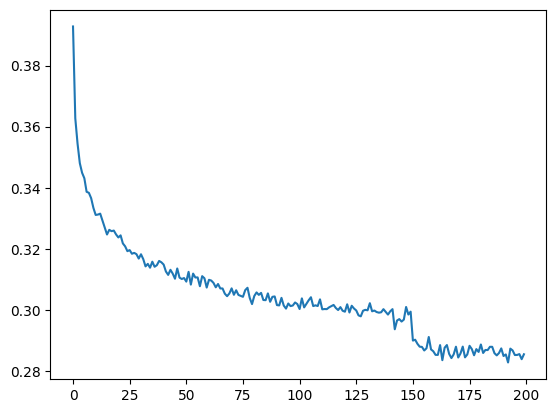

In [45]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))# converted the means to be 1000 in 200 rows and taking mean of the losses in each 200 rows and plotting it

In [12]:
# put layers into eval mode (needed for batchnorm  especially)
for layer in model.layers:
  layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  # emb = C[x]
  # x = emb.view(emb.shape[0], -1)
  # for layer in layers:
  #   x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.7662863731384277
dev 1.9836548566818237


## performance log

- original (3 characters context + 200 hidden neurons, 12K params): train:2.058, val: 2.105

- context: 3 -> 8(22k params): train: 1.916, val: 2.027

In [14]:
# sample from the model
for _ in range(20):

  out = []
  context = [0] * block_size# initiate with all ...
  while True:
    logits = model(torch.tensor([context]))
    # emb = C[torch.tensor([context])]
    # x = emb.view(emb.shape[0], -1)
    # for layer in layers:
    #   x = layer(x)
    # logits = x
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))# decode and print the generated word

aidalah.
giusten.
loren.
sabas.
angelifa.
christen.
kendley.
candi.
poond.
layla.
sylvan.
denicie.
sudas.
daxphose.
jakir.
issa.
eden.
casmaguas.
iesman.
cobine.
